**HW4 - Adil Mert Ergörün**

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import manhattan_distances, cosine_distances, euclidean_distances

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Flatten the data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Normalize pixel values
X_train_flat = X_train_flat / 255.0
X_test_flat = X_test_flat / 255.0

# Check the data
print("X_train shape:", X_train_flat.shape)
print("X_test shape:", X_test_flat.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (60000, 784)
X_test shape: (10000, 784)


**CODE**

In [ ]:
def assign_labels(cluster_table):
    n_clusters, n_labels = cluster_table.shape

    # We keep track of the labels we added so we don't assign same label to two clusters
    cluster_labels = {}
    added_labels = set()

    # We keep going until every cluster has a label
    while len(cluster_labels) < n_clusters:
        max_val = -1
        max_c = -1
        max_l = -1

        for c in range(n_clusters):
            for l in range(n_labels):
                if cluster_table[c][l] > max_val and l not in added_labels and c not in cluster_labels:
                    max_val = cluster_table[c][l]
                    max_c = c
                    max_l = l

        if max_c != -1 and max_l != -1:
            cluster_labels[max_c] = max_l
            added_labels.add(max_l)

        # Handling remaining cases
        else:
            for c in range(n_clusters):
                if c not in cluster_labels:
                    for l in range(n_labels):
                        if l not in added_labels:
                            cluster_labels[c] = l
                            added_labels.add(l)
                            break

    return cluster_labels


def kmeans_clustering(X_train, y_train, metric='euclidean'):

    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)

    # 5 splits, %80 train and %20 test
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    train_accuracies = []
    test_accuracies = []
    train_conf_matrices = []
    test_conf_matrices = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        kmeans.fit(X_train_fold)
        train_clusters = kmeans.labels_

        # Preparing the cluster table as mentioned in the pdf
        cluster_table = np.zeros((10, 10), dtype=int)
        for i in range(len(train_clusters)):
            c = train_clusters[i]
            l = y_train_fold[i]
            cluster_table[c][l] += 1

        # Assigned labels as mentioned in the pdf
        labels = assign_labels(cluster_table)

        train_predictions = [labels[c] for c in train_clusters]
        train_conf_matrices.append(confusion_matrix(y_train_fold, train_predictions, labels=range(10)))
        train_accuracies.append(accuracy_score(y_train_fold, train_predictions))

        centers = kmeans.cluster_centers_

        if metric == 'euclidean':
            distances = euclidean_distances(X_test_fold, centers)
        elif metric == 'manhatten':
            distances = manhattan_distances(X_test_fold, centers)
        elif metric == 'cosine':
            distances = cosine_distances(X_test_fold, centers)

        test_clusters = np.argmin(distances, axis=1)

        test_predictions = [labels[c] for c in test_clusters]
        test_conf_matrices.append(confusion_matrix(y_test_fold, test_predictions, labels=range(10)))
        test_accuracies.append(accuracy_score(y_test_fold, test_predictions))

    total_train_conf = sum(train_conf_matrices)
    total_test_conf = sum(test_conf_matrices)

    return np.mean(train_accuracies), np.mean(test_accuracies), total_train_conf, total_test_conf

In [2]:
# A basic function for plotting the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Running KMeans algorithm with different metrics.

Running with metric: euclidean
Avarage train Accuracy: 0.5213541666666666

Total train confussion matrix:


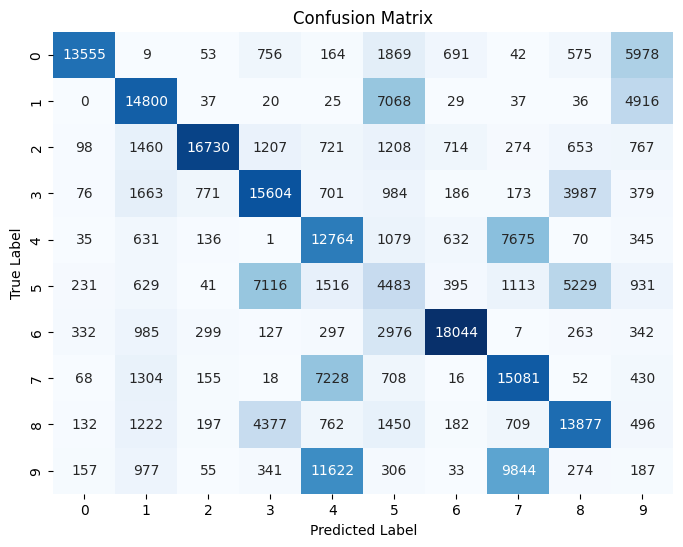

Avarage test Accuracy: 0.5203666666666666

Total test confussion matrix:


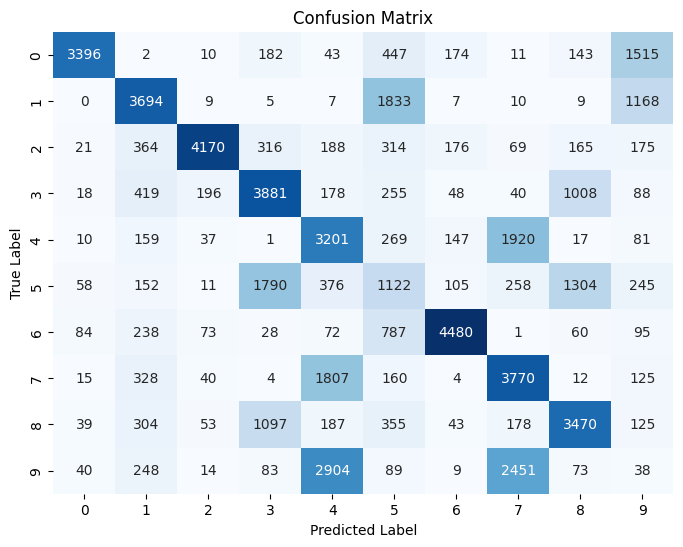


Running with metric: manhatten
Avarage train Accuracy: 0.5213541666666666

Total train confussion matrix:


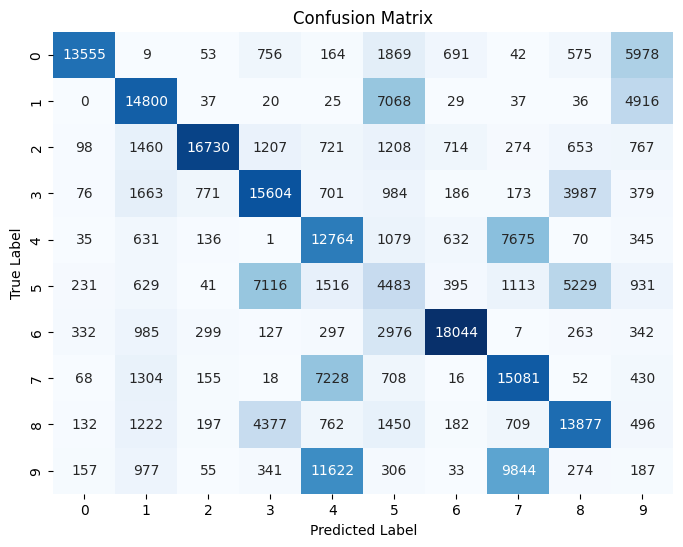

Avarage test Accuracy: 0.42015

Total test confussion matrix:


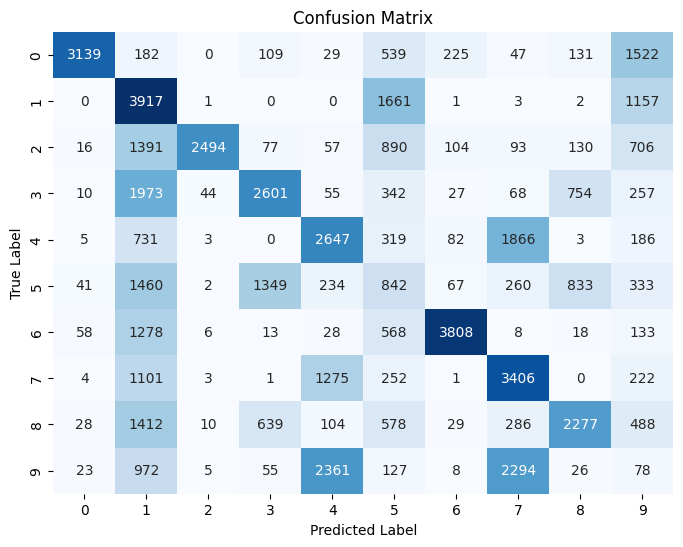


Running with metric: cosine
Avarage train Accuracy: 0.5213541666666666

Total train confussion matrix:


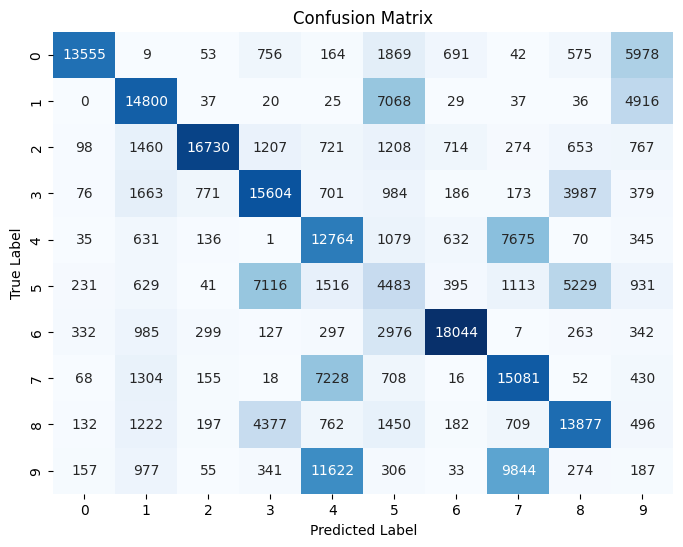

Avarage test Accuracy: 0.5285666666666666

Total test confussion matrix:


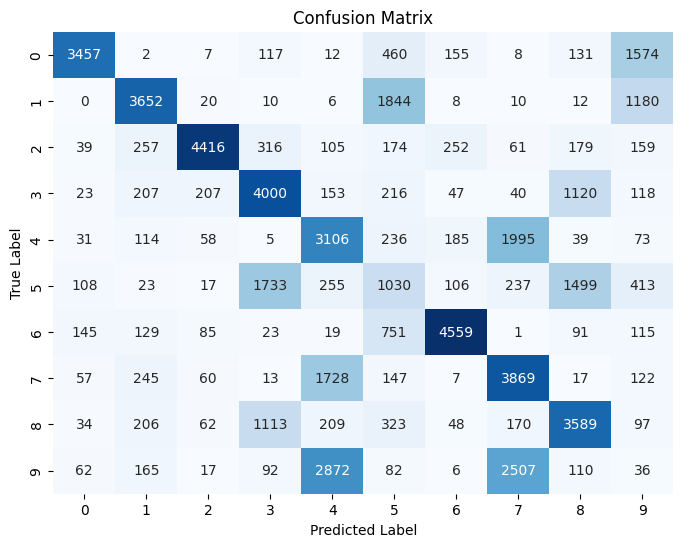


Summary:

Metric: euclidean
Train Accuracy: 0.5213541666666666
Test Accuracy: 0.5203666666666666

Metric: manhatten
Train Accuracy: 0.5213541666666666
Test Accuracy: 0.42015

Metric: cosine
Train Accuracy: 0.5213541666666666
Test Accuracy: 0.5285666666666666


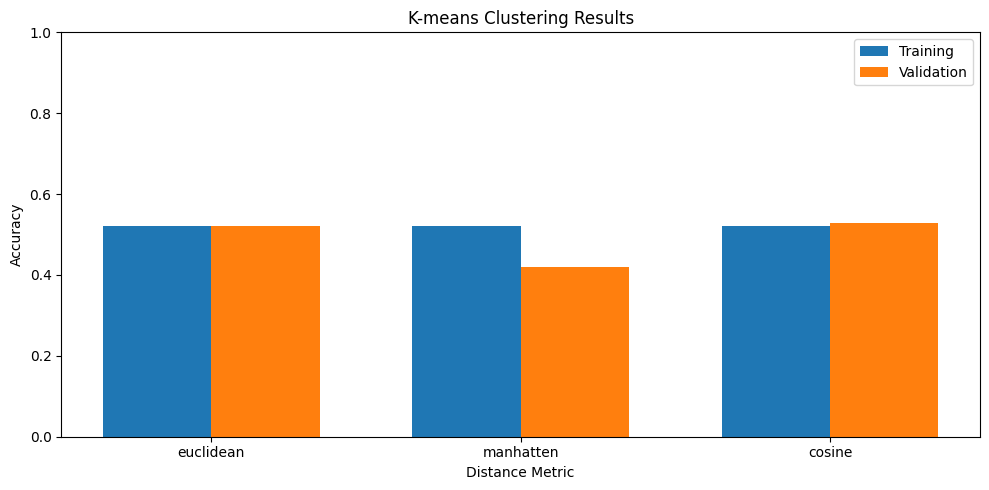

In [ ]:
metrics = ['euclidean', 'manhatten', 'cosine']
results = []

print("Running KMeans algorithm with different metrics.")
for metric in metrics:
    print(f"\nRunning with metric: {metric}")
    train_acc, test_acc, total_train_conf, total_test_conf = kmeans_clustering(X_train_flat, y_train, metric)

    print(f"Avarage train Accuracy: {train_acc}")

    print(f"\nTotal train confussion matrix:")
    plot_confusion_matrix(total_train_conf, range(10))

    print(f"Avarage test Accuracy: {test_acc}")

    print(f"\nTotal test confussion matrix:")
    plot_confusion_matrix(total_test_conf, range(10))


    results.append({
        'Metric': metric,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Total Train Confusion Matrix': total_train_conf,
        'Total Test Confusion Matrix': total_test_conf
    })

# Summary

print("\nSummary:")
for result in results:
    print(f"\nMetric: {result['Metric']}")
    print(f"Train Accuracy: {result['Train Accuracy']}")
    print(f"Test Accuracy: {result['Test Accuracy']}")

# Plot results

metrics = [result['Metric'] for result in results]
train_accuracies = [result['Train Accuracy'] for result in results]
test_accuracies = [result['Test Accuracy'] for result in results]

plt.figure(figsize=(10, 5))

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, train_accuracies, width, label='Training')
plt.bar(x + width/2, test_accuracies, width, label='Validation')

plt.xlabel('Distance Metric')
plt.ylabel('Accuracy')
plt.title('K-means Clustering Results')
plt.xticks(x, metrics)
plt.legend()
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

**RESULTS**

Euclidean:

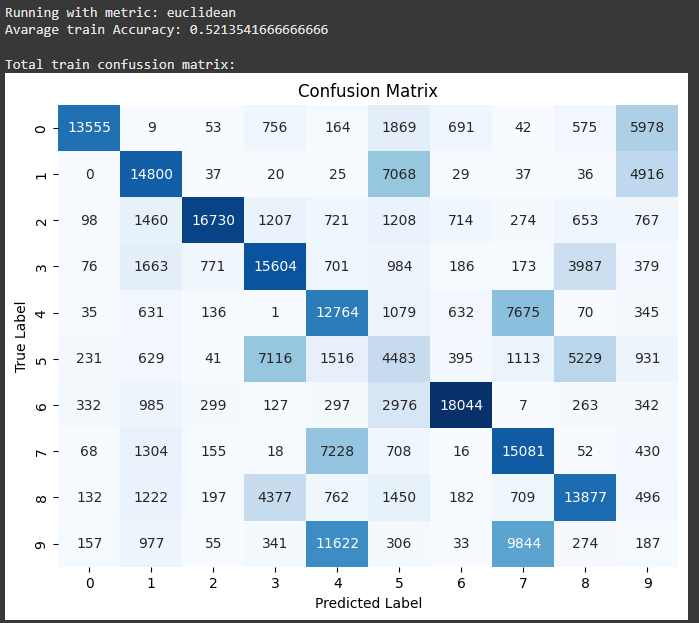

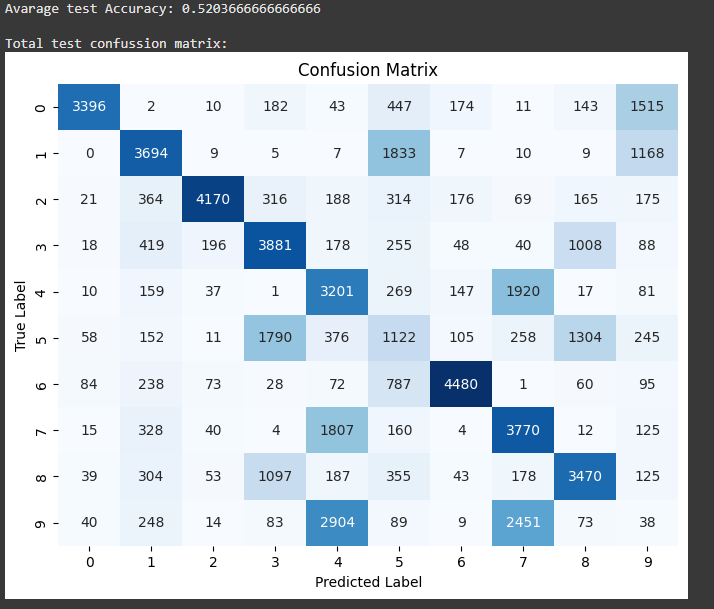

Manhatten:

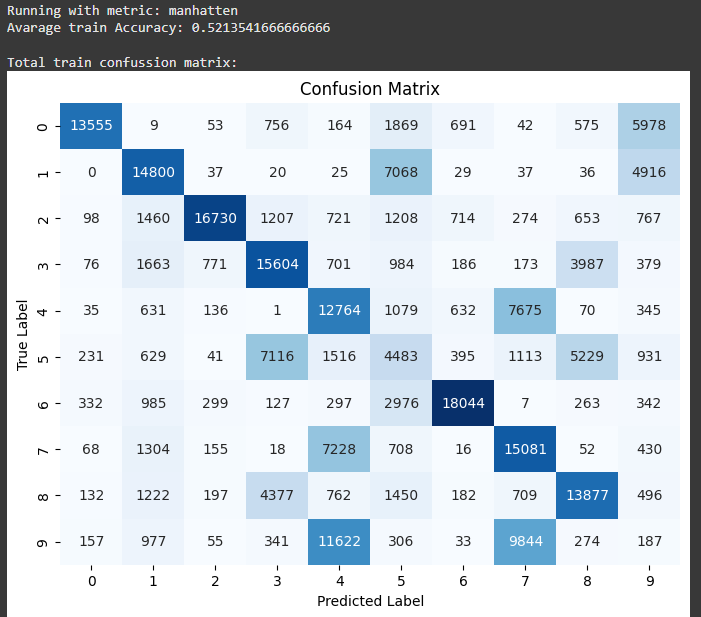

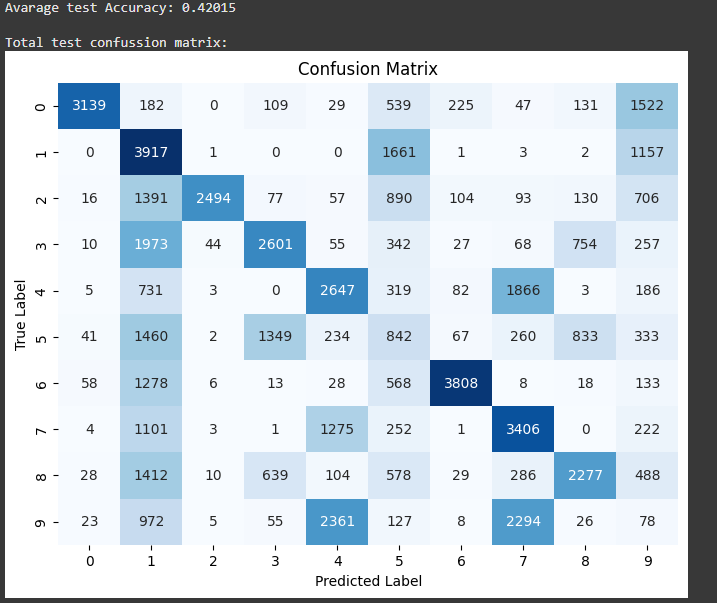

Cosine:

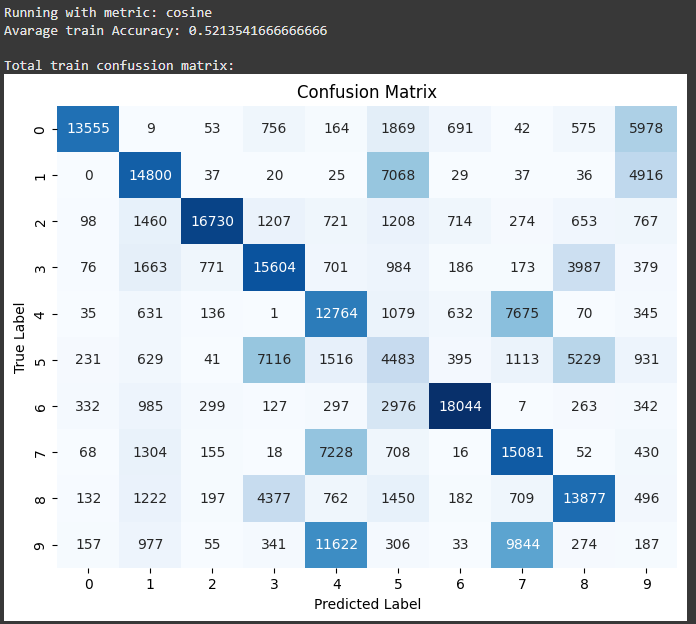

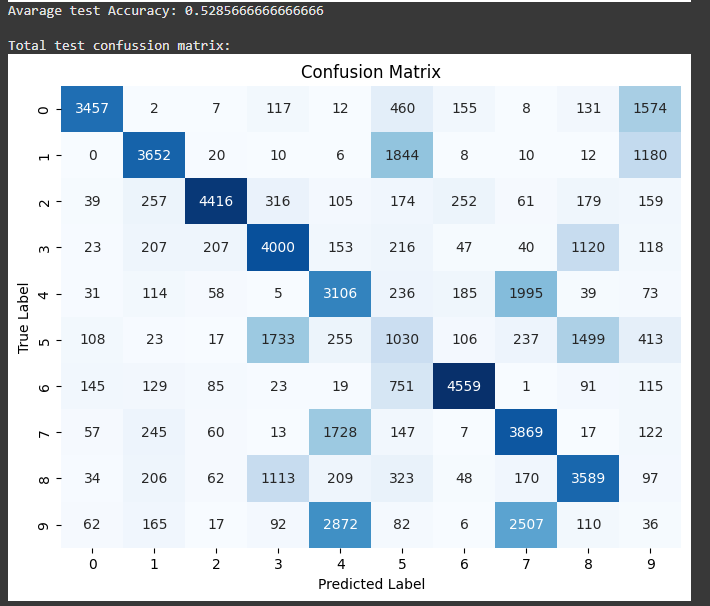

Overall:

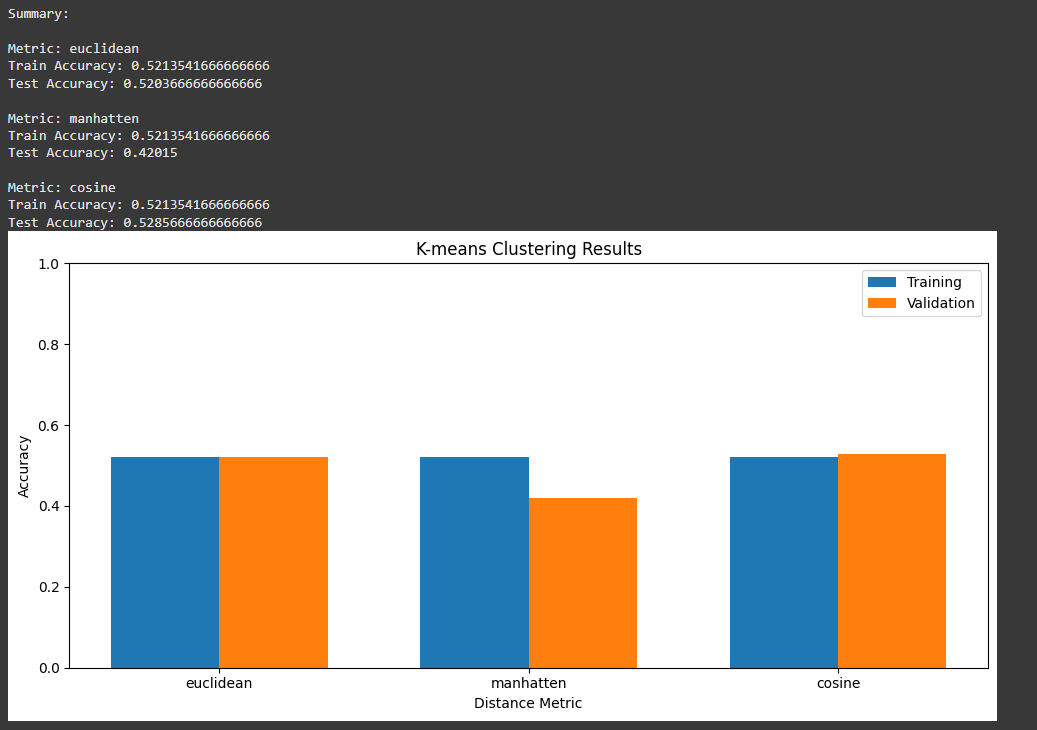

**Conclusion**

Overall, all of the distance metrics achieved similar results. Among them the best performing one was cosine, followed by euclidean and at last manhattan. Cosine performed best, probably because digit recognition benefits more from orientation similarity than absolute distance. From our results we can conclude that cosine metric represents the structural similarities between handwritten digits better than other metrics.


---

The confusion matrices reveal that certain digits are consistently misclassified regardless of the distance metric used. Especially digits 9 and 5 show considerable confusion with other digits.

Digits 1, 2, 3 and 6 appear to be clustered more accurately across all metrics.



---

In conclusion, K-Means clustering with any of these distance metrics achieves only moderate accuracy on this dataset (all aroung %50). Cosine distance metric seems to be the best performing metric, although difference is not significant. It seems for our dataset orientation similarity captured by cosine metric is more beneficial than spatial distance captured by other metrics.